Hildegard Zerrweck
A00838300

In [1]:
# importa las librerías
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from numpy import array
from sklearn.metrics import classification_report
import time
from sklearn.metrics import confusion_matrix
import sklearn.model_selection as model_selection

In [2]:
pip install medmnist

Note: you may need to restart the kernel to use updated packages.


In [3]:
import medmnist
from medmnist import INFO

In [4]:
DATASET_NAME = "pneumoniamnist"
info = INFO[DATASET_NAME]
print(info)

{'python_class': 'PneumoniaMNIST', 'description': 'The PneumoniaMNIST is based on a prior dataset of 5,856 pediatric chest X-Ray images. The task is binary-class classification of pneumonia against normal. We split the source training set with a ratio of 9:1 into training and validation set and use its source validation set as the test set. The source images are gray-scale, and their sizes are (384−2,916)×(127−2,713). We center-crop the images and resize them into 1×28×28.', 'url': 'https://zenodo.org/records/10519652/files/pneumoniamnist.npz?download=1', 'MD5': '28209eda62fecd6e6a2d98b1501bb15f', 'url_64': 'https://zenodo.org/records/10519652/files/pneumoniamnist_64.npz?download=1', 'MD5_64': '8f4eceb4ccffa70c672198ea285246c6', 'url_128': 'https://zenodo.org/records/10519652/files/pneumoniamnist_128.npz?download=1', 'MD5_128': '05b46931834c231683c68f40c47b2971', 'url_224': 'https://zenodo.org/records/10519652/files/pneumoniamnist_224.npz?download=1', 'MD5_224': 'd6a3c71de1b945ea11211b

In [5]:
DataClass = getattr(medmnist, info["python_class"])

In [6]:
train_ds = DataClass(split = "train", download = True, as_rgb = False)
val_ds = DataClass(split = "val", download = True, as_rgb = False)
test_ds = DataClass(split = "test", download = True, as_rgb = False)

In [7]:
def dataset_to_numpy(dataset):
    images, labels = [], []
    for i in range(len(dataset)):
        img, label = dataset[i]
        images.append(img)
        labels.append(label)
    return np.array(images), np.array(labels).squeeze()

In [8]:
x_train, y_train = dataset_to_numpy(train_ds)
x_val, y_val = dataset_to_numpy(val_ds)
x_test, y_test = dataset_to_numpy(test_ds)


In [9]:
x_train = x_train.astype("float32") / 255.0
x_val = x_val.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0
# las imagenes de pneumoniamnist vienen en formato (N, 28, 28), por eso al final le agreegamos una None

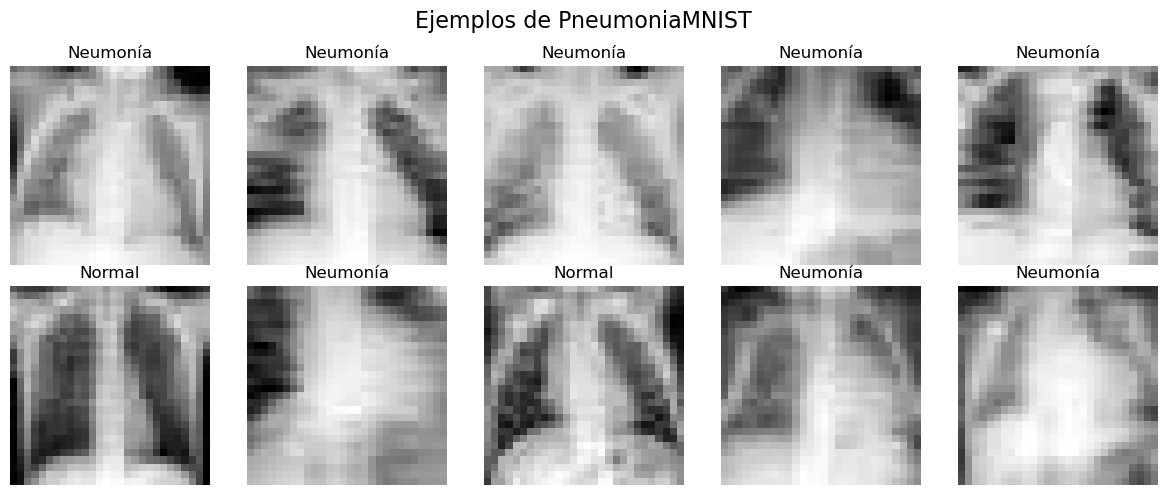

In [10]:
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
fig.suptitle("Ejemplos de PneumoniaMNIST", fontsize=16)

for i, ax in enumerate(axes.flat):
    img = x_train[i].squeeze()   # quitar canal si existe
    label = y_train[i]
    ax.imshow(img, cmap="gray")
    ax.set_title("Normal" if label == 0 else "Neumonía")
    ax.axis("off")

plt.tight_layout()
plt.show()

In [11]:
AUTOTUNE = tf.data.AUTOTUNE
BATCH = 64

In [12]:
def prep_example(x, y):
    x = tf.cast(x, tf.float32) / 255.0
    x = tf.reshape(x, [28,28,1])
    y = tf.cast(y, tf.int32)
    return x, y

In [13]:
train_tf = (tf.data.Dataset.from_tensor_slices((x_train, y_train))
            .map(prep_example, num_parallel_calls=AUTOTUNE)
            .shuffle(10_000)
            .batch(BATCH)
            .prefetch(AUTOTUNE))

val_tf = (tf.data.Dataset.from_tensor_slices((x_val, y_val))
          .map(prep_example, num_parallel_calls=AUTOTUNE)
          .batch(BATCH)
          .prefetch(AUTOTUNE))

test_tf = (tf.data.Dataset.from_tensor_slices((x_test, y_test))
           .map(prep_example, num_parallel_calls=AUTOTUNE)
           .batch(BATCH)
           .prefetch(AUTOTUNE))

In [14]:
from tensorflow import keras
from tensorflow.keras import layers

In [15]:
model = keras.Sequential([
    # C1
    layers.Conv2D(filters=6, kernel_size=(5,5), strides=(1,1),
                  padding='same', activation='tanh',
                  input_shape=(28, 28, 1)),

    # S2
    layers.MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'),

    # C3
    layers.Conv2D(filters=16, kernel_size=(5,5), strides=(1,1),
                  padding='valid', activation='tanh'),

    # S4
    layers.MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'),

    # C5 + F6
    layers.Flatten(),
    layers.Dense(120, activation='tanh'),
    layers.Dense(84,  activation='tanh'),

    # Output (2 clases)
    layers.Dense(2, activation='softmax')
])

C:\Users\zerrw\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [16]:
# define algunos hiper-parámetros
n_epochs=25
n_batch=64
learning_rate=0.01
opt = tf.keras.optimizers.SGD(learning_rate=learning_rate)

In [17]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss='sparse_categorical_crossentropy',  # <— clave
    metrics=['accuracy']
)

In [18]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 6)      │           156 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 6)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 10, 10, 16)     │         2,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 400)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 120)            │        48,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 84)             │        10,164 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │           170 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 61,026 (238.38 KB)

 Trainable params: 61,026 (238.38 KB)

 Non-trainable params: 0 (0.00 B)

In [19]:
history = model.fit(
    train_tf,
    validation_data=val_tf,
    epochs=25,            
    verbose = 1
)

Epoch 1/25
74/74 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.7390 - loss: 0.5796 - val_accuracy: 0.7424 - val_loss: 0.5704
Epoch 2/25
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7421 - loss: 0.5604 - val_accuracy: 0.7424 - val_loss: 0.5129
Epoch 3/25
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8704 - loss: 0.2755 - val_accuracy: 0.9313 - val_loss: 0.1849
Epoch 4/25
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9252 - loss: 0.1828 - val_accuracy: 0.9313 - val_loss: 0.1680
Epoch 5/25
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9344 - loss: 0.1673 - val_accuracy: 0.9427 - val_loss: 0.1525
Epoch 6/25
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9361 - loss: 0.1587 - val_accuracy: 0.9408 - val_loss: 0.1460
Epoch 7/25
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9395 - loss: 0.1520 - val_accuracy: 0.9427 - val_loss: 0.1365
Epoch 8/25
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9439 - loss: 0.1430 - val_accuracy: 0.9408 - v

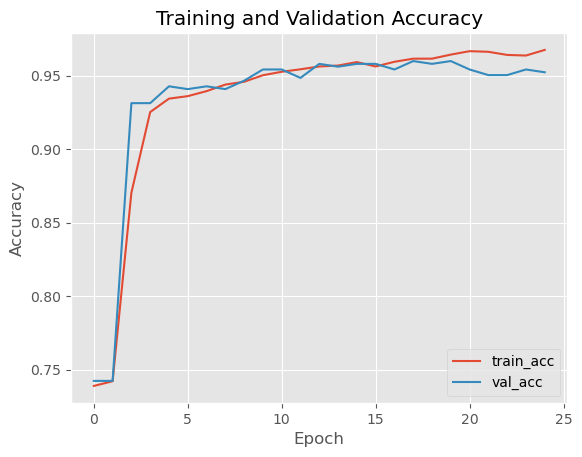

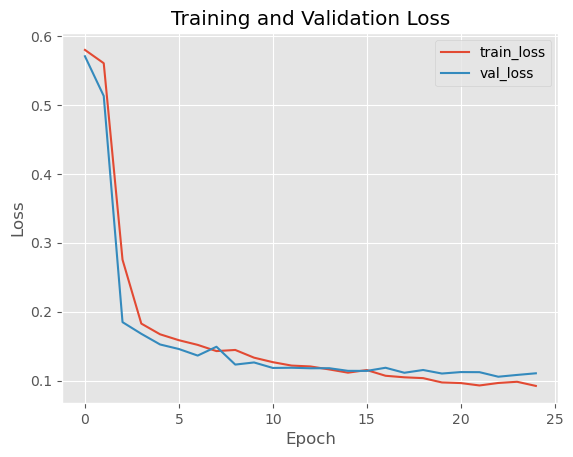

In [20]:
# Despliega las curvas de aprendizaje
H = history
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0,n_epochs),H.history["accuracy"],label="train_acc")
plt.plot(np.arange(0,n_epochs),H.history["val_accuracy"],label="val_acc")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.figure()
plt.plot(np.arange(0,n_epochs),H.history["loss"],label="train_loss") 
plt.plot(np.arange(0,n_epochs),H.history["val_loss"],label="val_loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

In [21]:
from sklearn.metrics import classification_report
import seaborn as sns

In [22]:
y_true = np.concatenate([y for _, y in test_tf], axis=0)
y_prob = model.predict(test_tf)
y_pred = y_prob.argmax(axis=1)
labels = ["Normal", "Neumonía"]
print(classification_report(y_true, y_pred, target_names=labels))


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step 
              precision    recall  f1-score   support

      Normal       0.98      0.60      0.74       234
    Neumonía       0.80      0.99      0.89       390

    accuracy                           0.84       624
   macro avg       0.89      0.80      0.82       624
weighted avg       0.87      0.84      0.83       624



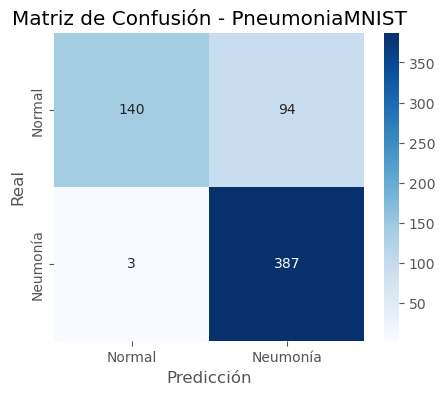

In [23]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión - PneumoniaMNIST")
plt.show()

### Conclusión

El desarrollo de esta actividad me permitió poner en práctica de manera integral varios conceptos de redes neuronales convolucionales, desde la preparación de datos hasta la evaluación del modelo. Comenzar trabajando con el dataset PneumoniaMNIST fue muy enriquecedor, ya que se trata de un caso real de imágenes médicas y me permitió comprender la importancia de adaptar arquitecturas clásicas como LeNet-5 a problemas actuales de clasificación. Durante el proceso me enfrenté a diversos retos técnicos relacionados con las dimensiones de los tensores y el preprocesamiento de imágenes, lo que me ayudó a reforzar mi entendimiento sobre cómo TensorFlow y Keras manejan la forma de los datos en cada etapa del pipeline. Resolver estos problemas me hizo más consciente de la importancia de validar las dimensiones y de construir pipelines eficientes con tf.data.

Además, al entrenar el modelo pude observar de primera mano cómo métricas como precisión, recall y f1-score reflejan el desempeño de la red en un problema sensible como la detección de neumonía. Visualizar la matriz de confusión me permitió identificar de manera más clara dónde se concentran los aciertos y errores, lo que es fundamental en contextos médicos. También fue muy útil desplegar ejemplos del dataset al inicio para relacionar mejor los resultados del modelo con las imágenes originales.